In [161]:
using Plots, Distributions, ColorSchemes, Statistics, LinearAlgebra, GeometryBasics, 
        VoronoiCells, Distances, ProgressMeter, Random
default(size=(500,500), titlefontsize=10)
Random.seed!(1234);

In [162]:
function random_points(N::Integer=1)
    
    coordinates = rand(Uniform(),N,2)
    points = [Point2(coordinates[i,:]) for i=1:N]
    return points
end

random_points (generic function with 2 methods)

In [163]:
function rbf(x::Point2;
                weights::Vector{Float64}=[1.0],
                centers::Vector{Point2{Float64}}=[Point2(0.0,0.0)],
                sigma2::Vector{Float64}=[1.0])
    
    @assert length(weights)==length(centers)==length(sigma2)>0 #chequeo consistencia de n>0
    n=length(weights)

    @assert length(x)==length(centers[1]) #chequeo que los centros tengan la dim de x.
    d=length(x)

    
    kernels = [exp(-Euclidean()(x,centers[j])^2/(2*sigma2[j])) for j=1:n]
    return sum(weights.*kernels)
    
end

rbf (generic function with 1 method)

In [164]:
function sample_rbf(N,rbf_func,cota=2.0)
    
    v=Vector{Point2}(undef,N)
    n=0
    
    while(n<N)
        
        x=random_points()[1]
        val  = rbf_func(x)

        u = rand(Uniform())
        
        if val/cota > u
            #accept
            n=n+1
            v[n] = x
        end
    end
    return v
end

sample_rbf (generic function with 2 methods)

## Ground truth

Trabajo en el cuadrado $[0,1]\times [0,1]$. Ponemos 3 centros y 20 puntos de medida

In [165]:
centers = Point2{Float64}[]
push!(centers,Point2(0.6,0.1))
push!(centers,Point2(0.1,0.7))
push!(centers,Point2(0.3,0.4))
push!(centers,Point2(0.8,0.6))

    
mu=centers
sigmas = [.2,.2,.3,.1]
w = [1.0,1.0,1.0,2.0]

4-element Vector{Float64}:
 1.0
 1.0
 1.0
 2.0

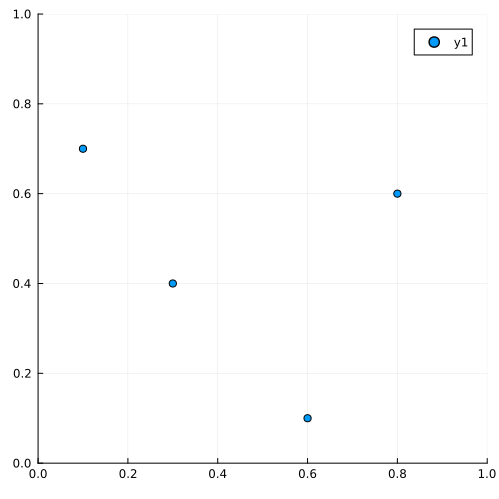

In [166]:
scatter(centers,aspect_ratio=:equal,xlims=(0,1),ylims=(0,1))

#### Ajusto para que sea una densidad de probabilidad

In [167]:
#estimo por montecarlo la integral

N=100000
U = random_points(N)
est = mean(rbf.(U, weights=w,centers=centers,sigma2=sigmas.^2))
scaled_w = w/est
densidad(x::Point2) = rbf(x, weights=scaled_w,centers=centers,sigma2=sigmas.^2)

##chequeo, deberia dar 1
U = random_points(N)
est2 = mean(densidad.(U))

1.0003685851265294

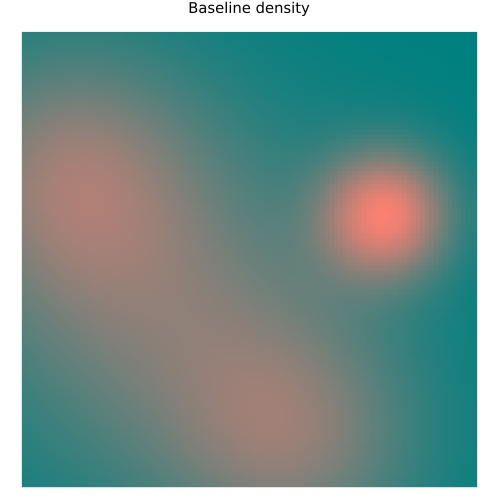

In [168]:
x1=(0:.01:1)
x2=(0:.01:1)

x=[Point2(a,b) for b in x2, a in x1] ##el orden de b y a importa no entendí por qué.

z = densidad.(x)

heatmap(x1,x2,z,
    c=cgrad([:teal, :salmon]),
    axis=false, 
    ticks=false, 
    lims=(0,1),
    colorbar=:none, 
    aspectratio=:equal, 
    legend=:none,    
    title="Baseline density")
#savefig("baseline_density.pdf")

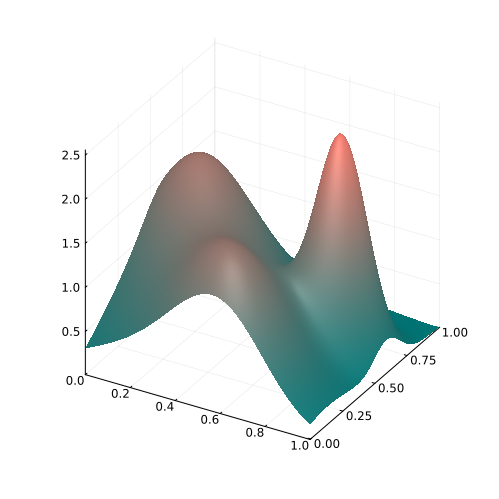

In [169]:
surface(x1,x2,z, colorbar=:none, 
    aspectratio=:equal,c=cgrad([:teal, :salmon]))

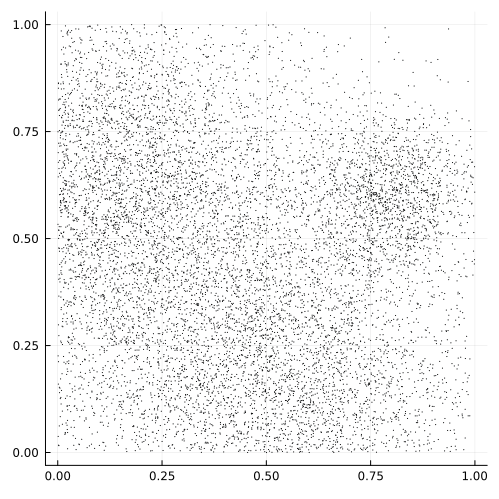

In [170]:
#genero los puntos. La densidad es lambda*g con g rbf la anterior
lambda = 10000.0
Nx = rand(Poisson(lambda))
    
Phi = sample_rbf(Nx,densidad,3)
scatter(Phi,ms=0.1, label=:none)

In [171]:
nu=1/200
consumos = rand(Exponential(1/nu),Nx);

### Genero sitios de medida

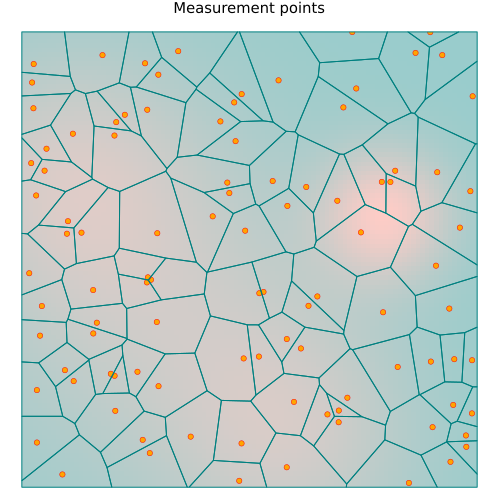

In [172]:
m=100

sites=random_points(m)

heatmap(x1,x2,z,
    c=cgrad([:teal, :salmon]),
    axis=false, 
    ticks=false, 
    lims=(0,1),
    colorbar=:none, 
    aspectratio=:equal, 
    legend=:none,
    alpha=0.4,
    title="Measurement points")
scatter!(sites, 
    markersize=3,
    marker=:circle,
    color=:orange,
    markerstrokecolor=:red,
    msw=.5,
    legend=:none, 
)
    
rect = Rectangle(Point2(0.0, 0.0), Point2(1.0, 1.0))
tess = voronoicells(sites, rect);
plot!(tess, color=:teal)
#savefig("measurement_points.pdf")

### Asocio los puntos

In [173]:
W = [Euclidean()(Phi[i],sites[j]) for i=1:Nx,j=1:m]

attachs = zeros(Int64,Nx)

for i=1:Nx
    _,idx = findmin(W[i,:])
    attachs[i] = idx
end

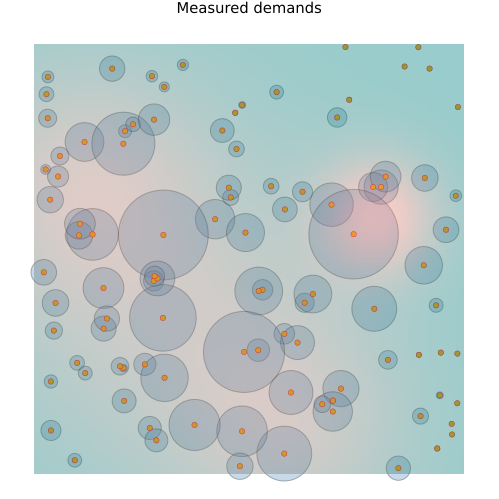

In [174]:
#Ahora en Phi estan los puntos, en consumos los consumos individuales y 
#en y guardo las medidas posta en los sites

y = [sum(consumos[attachs.==i]) for i=1:m]

scatter(sites, 
    markersize=y/maximum(y)*50,
    marker=:circle, 
    color=:steelblue,
    legend=:none, 
    markeralpha=0.3, 
    aspectratio=:equal, 
    ticks=false, 
    axis=false,
    title="Measured demands",
)

scatter!(sites, 
    markersize=3,
    marker=:circle,
    color=:orange,
    markerstrokecolor=:red,
    msw=.5,
    legend=:none, 
)

heatmap!(x1,x2,z,
    c=cgrad([:teal, :salmon]),
    alpha=0.4,
    axis=false, 
    ticks=false, 
    colorbar=:none)
#savefig("measured_demands.pdf")

### Histogram counts

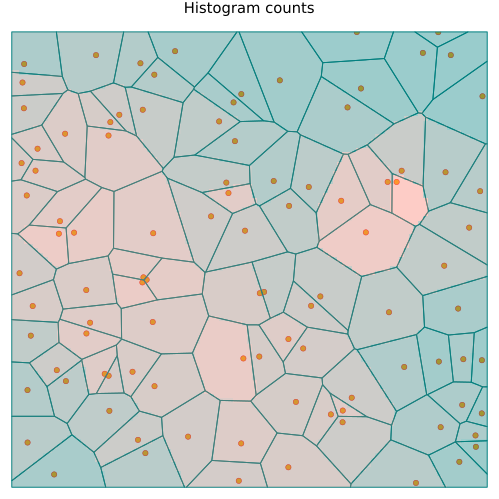

In [175]:
z_histogram = zeros(size(x))
site_counts = zeros(size(x))
        
for j in eachindex(z)
    
    distances = Euclidean().(Ref(x[j]),sites)
    _,idx = findmin(distances)
    site_counts[idx] = site_counts[idx]+1
end

for j in eachindex(z)
    
    distances = Euclidean().(Ref(x[j]),sites)
    _,idx = findmin(distances)
    z_histogram[j] = y[idx]/(site_counts[idx]/length(x))
end

scatter(sites, 
    markersize=3,
    marker=:circle,
    color=:orange,
    markerstrokecolor=:red,
    msw=.5,
    legend=:none, 
)
plot!(tess, color=:teal)

heatmap!(x1,x2,z_histogram,
    c=cgrad([:teal, :salmon]),
    alpha=0.4,
    axis=false, 
    ticks=false, 
    colorbar=:none, title="Histogram counts")

#savefig("histogram_counts.pdf")

# Initial condition

In [176]:
using Clustering
sites_matrix = zeros(2,m)
for j=1:m
    sites_matrix[:,j] =[sites[j].data[1],sites[j].data[2]]
end

n=4
km = kmeans(sites_matrix, n, weights=y)
mu0 = [Point2(km.centers[:,i]) for i=1:n]

sigma0 = zeros(n)
for i=1:n
    
    sigma0[i] = sqrt.(mean(km.costs[km.assignments.==i]))
end

### Initial weights

In [177]:
function average_over_voronoi(f::Function, u::Vector{Point2{Float64}}, sites::Vector{Point2{Float64}})

    N=length(u)
    F = zeros(length(sites))
    for k=1:N
        _,idx = findmin(Euclidean().(sites,Ref(u[k])))
        F[idx]+=f(u[k])
    end

    integrals = 1/N * F
    
end


average_over_voronoi (generic function with 1 method)

In [178]:
function update_w(mu,sigma2,y,sites,u,area=1.0)

    A=zeros(length(sites),length(mu))

    for j=1:length(mu)
        A[:,j] = average_over_voronoi(x->rbf(x;weights=[1.0],centers=[mu[j]],sigma2=[sigma2[j]]), u, sites)*area
    end
    return A\y
end

update_w (generic function with 2 methods)

In [179]:
U = random_points(100000)

w0 = update_w(mu0, sigma0.^2, y, sites, U)

4-element Vector{Float64}:
 2.603961344779808e6
 2.1570664660584903e6
 1.4338972683881207e6
 2.326979811575441e6

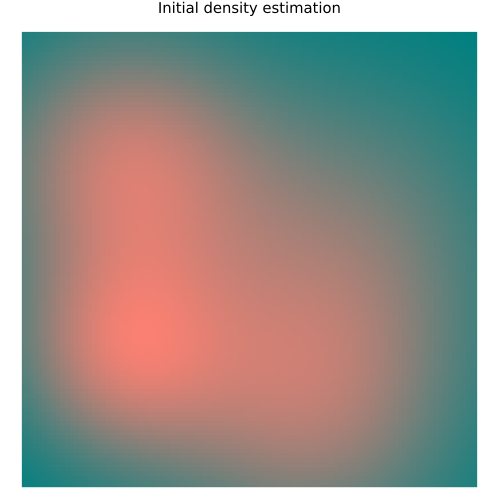

In [180]:
z0 = rbf.(x,weights=w0,centers=mu0,sigma2=sigma0.^2)

heatmap(x1,x2,z0,
    c=cgrad([:teal, :salmon]),
    axis=false, 
    ticks=false, 
    lims=(0,1),
    colorbar=:none, 
    aspectratio=:equal, 
    legend=:none,    
    title="Initial density estimation")

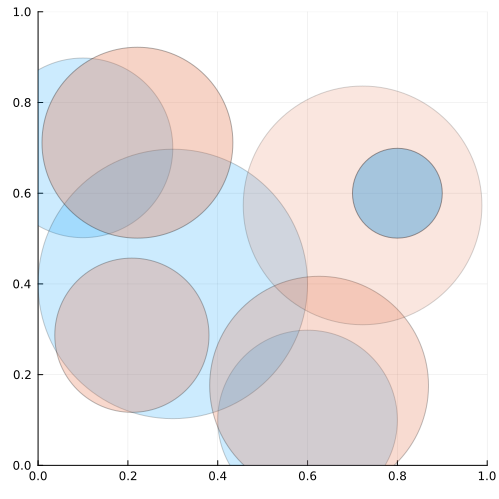

In [181]:
scatter(mu, ms = 500*sigmas, lims=(0,1), alpha=w/sum(w), legend=:none)
scatter!(mu0, ms=500*sigma0, alpha=w0/sum(w0))

## RBF y mean square error

In [182]:
west = w0/sum(y)
muest = mu0
sigma2est = sigma0.^2

#renormalizo y para el ajuste y después deshago
y_norm = y/sum(y);

In [183]:
function compute_gradient(w::Vector{Float64},mu::Vector{Point2{Float64}},sigma2::Vector{Float64},
                          y::Vector{Float64}, sites::Vector{Point2{Float64}}, u::Vector{Point2{Float64}}, 
                          area::Float64=1.0)

    yact = average_over_voronoi(x->rbf(x,weights=w,centers=mu,sigma2=sigma2), u, sites)*area;
    residuals = (yact - y)
    loss = sum(residuals.^2)
    
    k=length(w) #no. de nucleos
    
    dw = zeros(k)
    dmu1 = zeros(k)
    dmu2 = zeros(k)
    dsigma = zeros(k)
    
    for i=1:k
        dw[i] = residuals'*average_over_voronoi(x->rbf(x,weights=[1.0],centers=[mu[i]],sigma2=[sigma2[i]]), u, sites)*area;
        dmu1[i] = residuals'*average_over_voronoi(x->(x[1]-mu[i][1])/(2*sigma2[i])*rbf(x,weights=[w[i]],centers=[mu[i]],sigma2=[sigma2[i]]), u, sites)*area;
        dmu2[i] = residuals'*average_over_voronoi(x->(x[2]-mu[i][2])/(2*sigma2[i])*rbf(x,weights=[w[i]],centers=[mu[i]],sigma2=[sigma2[i]]), u, sites)*area;
        dsigma[i] = residuals'*average_over_voronoi(x->sum((x-mu[i]).^2)/(2*sigma2[i]^2)*rbf(x,weights=[w[i]],centers=[mu[i]],sigma2=[sigma2[i]]), u, sites)*area;
    end

    dmu = [Point2(dmu1[i],dmu2[i]) for i=1:k]
    return dw,dmu,dsigma,loss, residuals
end


compute_gradient (generic function with 2 methods)

In [184]:
N=10000

niter=500
L=zeros(niter)

step_size = 0.2
@showprogress for iter=1:niter

    u = random_points(N)

    dw,dmu,dsigma,loss,residuals = compute_gradient(west,muest,sigma2est,y_norm,sites,u)

    muest = muest - step_size*dmu
    
    sigma2est = sigma2est - step_size*dsigma
    west = update_w(muest,sigma2est,y_norm,sites,u)
    L[iter] = loss
end

Progress: 100%|█████████████████████████████████████████| Time: 0:01:14


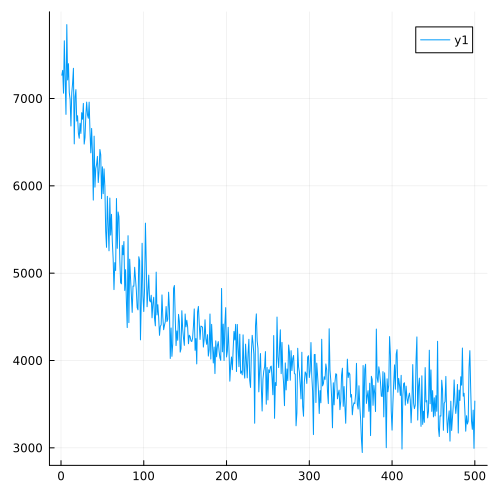

In [185]:
plot(sqrt.(L/length(y)).*sum(y))

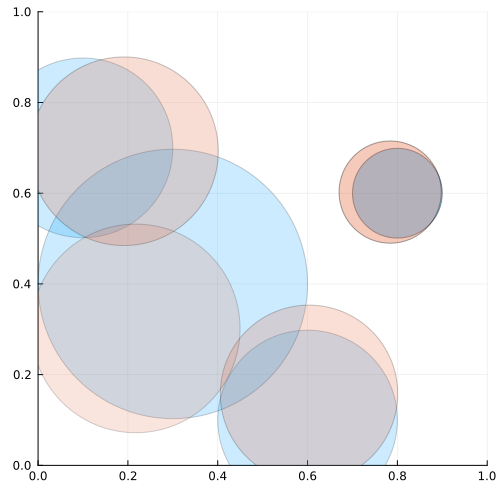

In [186]:
scatter(mu, ms = 500*sigmas, lims=(0,1), alpha=w/sum(w), legend=:none)
scatter!(muest, ms=500*sqrt.(sigma2est), alpha=west/sum(west))

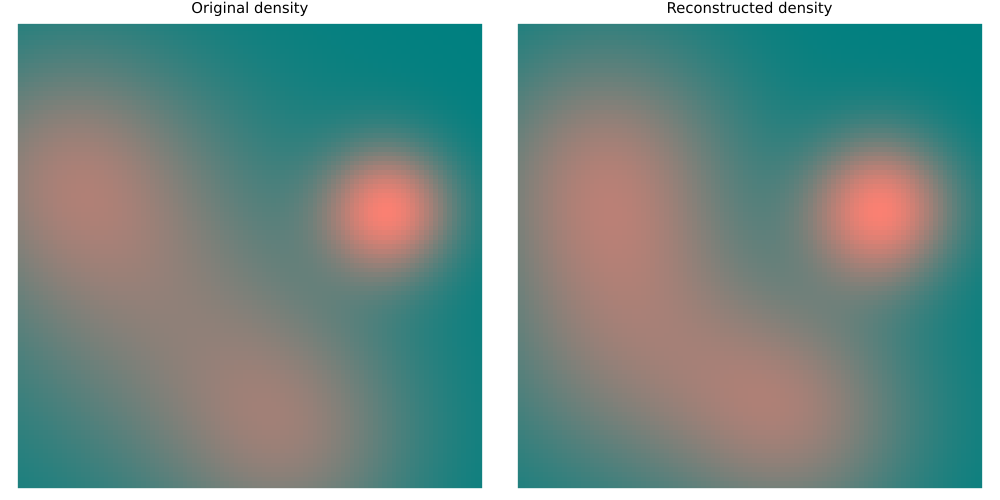

In [187]:
zest = rbf.(x,weights=west*sum(y),centers=muest,sigma2=sigma2est)

plot(
    heatmap(x1,x2,lambda/nu*z,
        c=cgrad([:teal, :salmon]),
        axis=false, 
        ticks=false, 
        lims=(0,1),
        colorbar=:none, 
        aspectratio=:equal, 
        legend=:none,    
        title="Original density")
    , 
    heatmap(x1,x2,zest,
        c=cgrad([:teal, :salmon]),
        axis=false, 
        ticks=false, 
        lims=(0,1),
        colorbar=:none, 
        aspectratio=:equal, 
        legend=:none,    
        title="Reconstructed density"),
layout = (1, 2), size=(1000,500))

## Maximum likelihood estimation

In [239]:
nu0 = 1/100
nuest=nu0
lambdaest = sum(y)*nu0
west = w0/sum(y)
muest = mu0
sigma2est = sigma0.^2
west

4-element Vector{Float64}:
 1.289504444573988
 1.068198189961663
 0.7100784749956939
 1.1523407655324502

In [240]:
function compute_gradient_ll(w::Vector{Float64},mu::Vector{Point2{Float64}},sigma2::Vector{Float64},
                          y::Vector{Float64}, n::Vector{Float64}, sites::Vector{Point2{Float64}}, u::Vector{Point2{Float64}}, 
                          area::Float64=1.0)

    lambda_est=sum(n)
    p_act = average_over_voronoi(x->rbf(x,weights=w,centers=mu,sigma2=sigma2), u, sites)*area;
    residuals = (n./p_act .- lambda_est)
    loss = sum(residuals.^2)
    
    k=length(w) #no. de nucleos
    
    dw = zeros(k)
    dmu1 = zeros(k)
    dmu2 = zeros(k)
    dsigma = zeros(k)
    
    for i=1:k
        dw[i] = residuals'*average_over_voronoi(x->rbf(x,weights=[1.0],centers=[mu[i]],sigma2=[sigma2[i]]), u, sites)*area;
        dmu1[i] = residuals'*average_over_voronoi(x->(x[1]-mu[i][1])/(2*sigma2[i])*rbf(x,weights=[w[i]],centers=[mu[i]],sigma2=[sigma2[i]]), u, sites)*area;
        dmu2[i] = residuals'*average_over_voronoi(x->(x[2]-mu[i][2])/(2*sigma2[i])*rbf(x,weights=[w[i]],centers=[mu[i]],sigma2=[sigma2[i]]), u, sites)*area;
        dsigma[i] = residuals'*average_over_voronoi(x->sum((x-mu[i]).^2)/(2*sigma2[i]^2)*rbf(x,weights=[w[i]],centers=[mu[i]],sigma2=[sigma2[i]]), u, sites)*area;
    end

    dmu = [Point2(dmu1[i],dmu2[i]) for i=1:k]
    return dw,dmu,dsigma,loss, residuals
end


compute_gradient_ll (generic function with 2 methods)

In [241]:
N=10000

niter=100
L=zeros(niter)

step_size = 0.000002
p_act=zeros(length(sites))
@showprogress for iter=1:niter

    u = random_points(N)
    p_act = average_over_voronoi(x->rbf(x,weights=west,centers=muest,sigma2=sigma2est), u, sites);

    n = sqrt.(lambdaest*(p_act/sum(p_act)).*nuest.*y)

    nuest = sum(n)/sum(y)
    lambdaest = sum(n)

    dw,dmu,dsigma,loss,residuals = compute_gradient_ll(west,muest,sigma2est,y,n,sites,u)

    muest = muest + step_size*dmu
    #println(dmu)
    sigma2est = sigma2est + step_size*dsigma
    #println(dsigma)
    west = west + step_size*dw
    #println(dw)
    L[iter] = loss
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:12


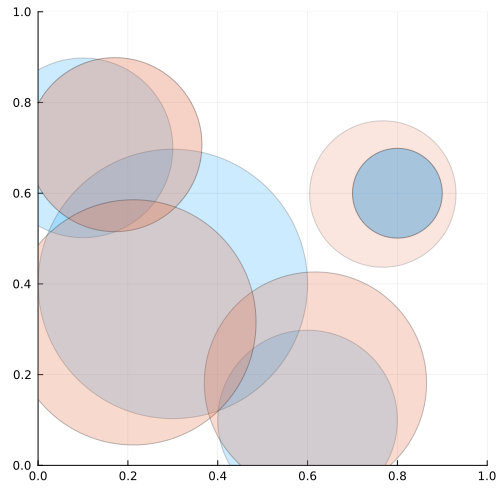

In [242]:
scatter(mu, ms = 500*sigmas, lims=(0,1), alpha=w/sum(w), legend=:none)
scatter!(muest, ms=500*sqrt.(sigma2est), alpha=west/sum(west))

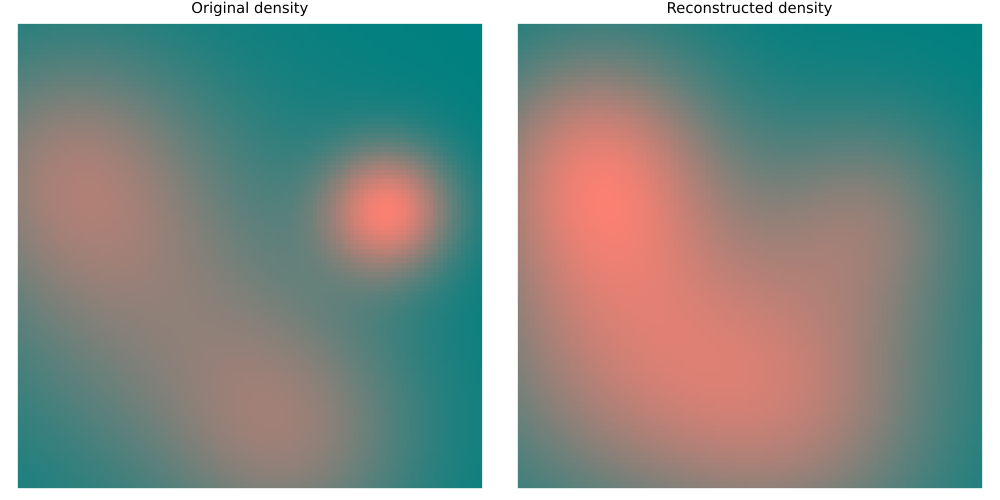

In [247]:
zest = rbf.(x,weights=west*lambdaest/nuest,centers=muest,sigma2=sigma2est)

plot(
    heatmap(x1,x2,lambda/nu*z,
        c=cgrad([:teal, :salmon]),
        axis=false, 
        ticks=false, 
        lims=(0,1),
        colorbar=:none, 
        aspectratio=:equal, 
        legend=:none,    
        title="Original density")
    , 
    heatmap(x1,x2,zest,
        c=cgrad([:teal, :salmon]),
        axis=false, 
        ticks=false, 
        lims=(0,1),
        colorbar=:none, 
        aspectratio=:equal, 
        legend=:none,    
        title="Reconstructed density"),
layout = (1, 2), size=(1000,500))

In [248]:
west

4-element Vector{Float64}:
 1.29074678983751
 1.0613353271081618
 0.744250802823495
 1.1395015801064874

In [249]:
lambdaest/nuest

2.0193504223555238e6

In [250]:
lambda/nu

2.0e6